In [1]:
# =========================
# 1) Setup + Libraries
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, Model

print("Libraries loaded ✅", tf.__version__)


Libraries loaded ✅ 2.20.0


In [2]:
# =========================
# 2) Dummy Dataset (same as ARIMA/SARIMA)
# =========================
np.random.seed(42)

n_days = 220
dates = pd.date_range("2025-08-01", periods=n_days, freq="D")

trend = np.linspace(30, 90, n_days)
weekly = 10 * np.sin(2 * np.pi * np.arange(n_days) / 7)
noise = np.random.normal(0, 4, n_days)

sales = np.maximum(0, trend + weekly + noise)

df = pd.DataFrame({"date": dates, "sales": sales})
df.head()


,date,sales
0,2025-08-01,31.986857
1,2025-08-02,37.539230
2,2025-08-03,42.887978
3,2025-08-04,41.252875
4,2025-08-05,25.820440


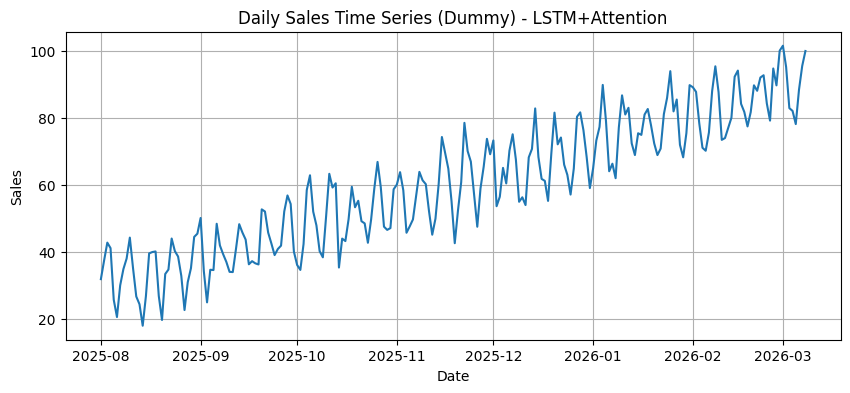

In [3]:
# =========================
# 3) Plot Series (optional screenshot once in report)
# =========================
plt.figure(figsize=(10,4))
plt.plot(df["date"], df["sales"])
plt.title("Daily Sales Time Series (Dummy) - LSTM+Attention")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


In [4]:
# =========================
# 4) Temporal Split 80/20
# =========================
y = pd.Series(df["sales"].values, index=df["date"]).astype(float)

split = int(len(y) * 0.8)
train = y.iloc[:split]
test  = y.iloc[split:]

print("Train size:", len(train))
print("Test size :", len(test))


Train size: 176
Test size : 44


In [6]:
# =========================
# 5) Scaling (fit ONLY on train to avoid leakage)
# =========================
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1)).astype(np.float32)
test_scaled  = scaler.transform(test.values.reshape(-1, 1)).astype(np.float32)


In [7]:
# =========================
# 6) Create supervised sequences
#    Lookback = number of past days used to predict next day
# =========================
LOOKBACK = 30

def make_sequences(series_2d, lookback):
    X, y = [], []
    for i in range(lookback, len(series_2d)):
        X.append(series_2d[i-lookback:i, 0])
        y.append(series_2d[i, 0])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X[..., None], y  # add feature dim

X_train, y_train = make_sequences(train_scaled, LOOKBACK)

print("X_train shape:", X_train.shape)  # (samples, timesteps, features)
print("y_train shape:", y_train.shape)


X_train shape: (146, 30, 1)
y_train shape: (146,)


In [8]:
# =========================
# 7) Attention Model (over time steps)
#    - LSTM returns sequences (one vector per time step)
#    - Attention learns weights over time steps
# =========================
class TemporalAttention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.score_dense = layers.Dense(1)  # score per timestep

    def call(self, lstm_outputs):
        # lstm_outputs: (batch, timesteps, hidden)
        scores = self.score_dense(lstm_outputs)            # (batch, timesteps, 1)
        weights = tf.nn.softmax(scores, axis=1)            # (batch, timesteps, 1)
        context = tf.reduce_sum(weights * lstm_outputs, axis=1)  # (batch, hidden)
        return context, tf.squeeze(weights, axis=-1)       # weights: (batch, timesteps)

def build_lstm_attention(lookback, n_features=1, units=64, dropout=0.2):
    inp = layers.Input(shape=(lookback, n_features))
    x = layers.LSTM(units, return_sequences=True)(inp)
    x = layers.Dropout(dropout)(x)

    context, attn_weights = TemporalAttention(name="temporal_attention")(x)
    out = layers.Dense(1)(context)

    model = Model(inputs=inp, outputs=[out, attn_weights], name="LSTM_Attention")
    return model

model = build_lstm_attention(LOOKBACK, n_features=1, units=64, dropout=0.2)

# We train ONLY on the prediction output (ignore weights in loss)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=[tf.keras.losses.MeanSquaredError(), None]
)

model.summary()


Model: "LSTM_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_attention              │ [(None, 64), (None,    │            65 │
│ (TemporalAttention)             │ 30)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,026 (66.51 KB)

 Trainable params: 17,026 (66.51 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# =========================
# 8) Train
# =========================
tf.random.set_seed(42)

history = model.fit(
    X_train,
    [y_train, np.zeros((len(y_train), LOOKBACK), dtype=np.float32)],  # dummy for attn output
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - loss: 0.1702 - val_loss: 0.2131
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0682 - val_loss: 0.0388
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0174 - val_loss: 0.0347
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0273 - val_loss: 0.0214
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0151 - val_loss: 0.0132
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0131 - val_loss: 0.0253
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0160 - val_loss: 0.0274
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0153 - val_loss: 0.0199
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0123 - val_loss: 0.0113
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0126 - val_loss: 0.0113
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0120 - val_loss: 0.0123


In [10]:
# =========================
# 9) Recursive forecasting for the whole test horizon
#    Predict 1-step ahead repeatedly for len(test)
# =========================
def recursive_forecast(model, train_scaled_2d, steps, lookback):
    window = train_scaled_2d[-lookback:].copy()  # shape (lookback, 1)
    preds = []
    attn_list = []

    for _ in range(steps):
        X = window.reshape(1, lookback, 1).astype(np.float32)
        yhat_scaled, attn = model.predict(X, verbose=0)
        yhat_scaled = float(yhat_scaled[0, 0])

        preds.append(yhat_scaled)
        attn_list.append(attn[0])  # (lookback,)

        # slide window
        window = np.vstack([window[1:], [[yhat_scaled]]])

    return np.array(preds, dtype=np.float32), np.array(attn_list, dtype=np.float32)

pred_scaled, attn_weights_all = recursive_forecast(model, train_scaled, steps=len(test), lookback=LOOKBACK)

# invert scaling
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).reshape(-1)


In [11]:
# =========================
# 10) Metrics (Screenshot candidate)
# =========================
mae  = mean_absolute_error(test.values, pred)
rmse = np.sqrt(mean_squared_error(test.values, pred))
mape = np.mean(np.abs((test.values - pred) / np.maximum(test.values, 1e-8))) * 100

print("LSTM + Attention Metrics")
print(f"Lookback: {LOOKBACK}")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


LSTM + Attention Metrics
Lookback: 30
MAE  : 8.20
RMSE : 9.89
MAPE : 9.22%


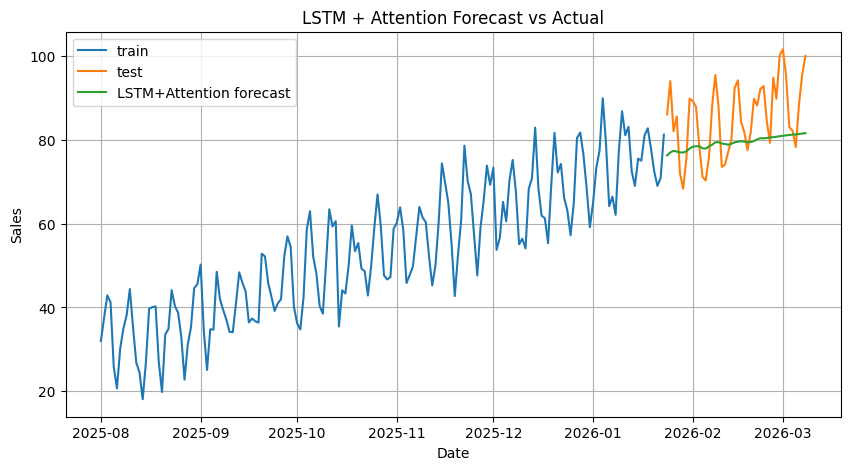

In [12]:
# =========================
# 11) Forecast vs Actual Plot (MOST IMPORTANT screenshot)
# =========================
plt.figure(figsize=(10,5))
plt.plot(train.index, train.values, label="train")
plt.plot(test.index, test.values, label="test")
plt.plot(test.index, pred, label="LSTM+Attention forecast")

plt.title("LSTM + Attention Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


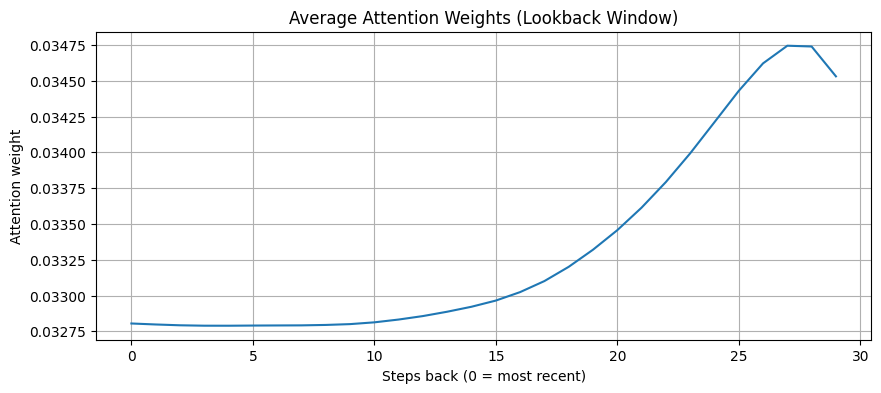

In [13]:
# =========================
# 12) (Optional) Attention interpretability plot
#     Show average attention over the forecast horizon
# =========================
avg_attn = attn_weights_all.mean(axis=0)  # (lookback,)

plt.figure(figsize=(10,4))
plt.plot(np.arange(LOOKBACK)[::-1], avg_attn)  # 0 = most recent if you reverse, so we invert axis view
plt.title("Average Attention Weights (Lookback Window)")
plt.xlabel("Steps back (0 = most recent)")
plt.ylabel("Attention weight")
plt.grid(True)
plt.show()


In [14]:
# =========================
# 13) Save results table (optional)
# =========================
results_lstm_attn = pd.DataFrame({
    "date": test.index,
    "y_true": test.values,
    "y_pred": pred
})
results_lstm_attn.head()


,date,y_true,y_pred
0,2026-01-24,86.089500,76.311470
1,2026-01-25,94.056566,76.995659
2,2026-01-26,82.047333,77.392914
3,2026-01-27,85.582935,77.218910
4,2026-01-28,72.068459,77.002945


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cpu


In [16]:
n_days = 220
dates = pd.date_range("2025-08-01", periods=n_days, freq="D")

trend = np.linspace(30, 90, n_days)
weekly = 10 * np.sin(2 * np.pi * np.arange(n_days) / 7)
noise = np.random.normal(0, 4, n_days)

sales = np.maximum(0, trend + weekly + noise)

df = pd.DataFrame({"date": dates, "sales": sales})
df.head()


,date,sales
0,2025-08-01,31.986857
1,2025-08-02,37.539230
2,2025-08-03,42.887978
3,2025-08-04,41.252875
4,2025-08-05,25.820440


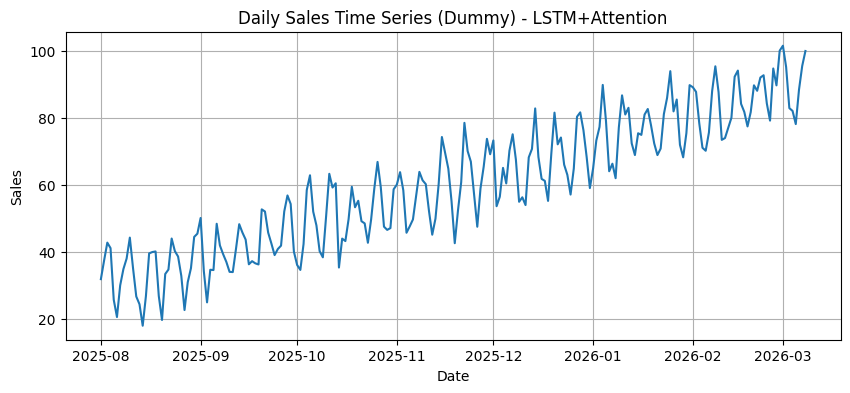

In [17]:
plt.figure(figsize=(10,4))
plt.plot(df["date"], df["sales"])
plt.title("Daily Sales Time Series (Dummy) - LSTM+Attention")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.grid(True); plt.show()


In [18]:
y = pd.Series(df["sales"].values, index=df["date"]).astype(float)

split = int(len(y) * 0.8)
train = y.iloc[:split]
test  = y.iloc[split:]

print("Train:", len(train), "Test:", len(test))


Train: 176 Test: 44


In [19]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1)).astype(np.float32)
test_scaled  = scaler.transform(test.values.reshape(-1, 1)).astype(np.float32)



In [20]:
LOOKBACK = 30

def make_sequences(arr_2d, lookback):
    X, y = [], []
    for i in range(lookback, len(arr_2d)):
        X.append(arr_2d[i-lookback:i, 0])
        y.append(arr_2d[i, 0])
    X = np.array(X, dtype=np.float32)[:, :, None]  # (N, T, 1)
    y = np.array(y, dtype=np.float32)[:, None]     # (N, 1)
    return X, y

X_train, y_train = make_sequences(train_scaled, LOOKBACK)
print(X_train.shape, y_train.shape)


(146, 30, 1) (146, 1)


In [21]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = SeqDataset(X_train, y_train)
dl = DataLoader(ds, batch_size=32, shuffle=True, drop_last=False)


In [22]:
class LSTMAttention(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        # score por timestep -> softmax
        self.score = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (B, T, 1)
        h_seq, _ = self.lstm(x)                 # (B, T, H)
        scores = self.score(h_seq)              # (B, T, 1)
        attn = torch.softmax(scores, dim=1)     # (B, T, 1)
        context = (attn * h_seq).sum(dim=1)     # (B, H)
        yhat = self.fc(context)                 # (B, 1)
        return yhat, attn.squeeze(-1)           # attn: (B, T)

model = LSTMAttention(hidden_size=64, num_layers=1, dropout=0.2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model


LSTMAttention(
  (lstm): LSTM(1, 64, batch_first=True)
  (score): Linear(in_features=64, out_features=1, bias=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [23]:
EPOCHS = 25
model.train()

for epoch in range(1, EPOCHS + 1):
    losses = []
    for xb, yb in dl:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        yhat, _ = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:02d} | loss {np.mean(losses):.6f}")


epoch 01 | loss 0.252072
epoch 05 | loss 0.032562
epoch 10 | loss 0.028349
epoch 15 | loss 0.025624
epoch 20 | loss 0.016655
epoch 25 | loss 0.015227


In [25]:
model.eval()

def recursive_forecast(model, train_scaled_2d, steps, lookback):
    window = train_scaled_2d[-lookback:].copy()  # (T,1)
    preds = []
    attns = []

    for _ in range(steps):
        X = torch.from_numpy(window.reshape(1, lookback, 1)).float().to(device)

        with torch.no_grad():
            yhat, attn = model(X)
        yhat = float(yhat.cpu().numpy()[0,0])
        preds.append(yhat)
        attns.append(attn.cpu().numpy()[0])  # (T,)

        window = np.vstack([window[1:], [[yhat]]])

    return np.array(preds, dtype=np.float32), np.array(attns, dtype=np.float32)

pred_scaled, attn_all = recursive_forecast(model, train_scaled, steps=len(test), lookback=LOOKBACK)
pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).reshape(-1)


In [26]:
mae  = mean_absolute_error(test.values, pred)
rmse = np.sqrt(mean_squared_error(test.values, pred))
mape = np.mean(np.abs((test.values - pred) / np.maximum(test.values, 1e-8))) * 100

print("LSTM + Attention Metrics (PyTorch)")
print(f"Lookback: {LOOKBACK}")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


LSTM + Attention Metrics (PyTorch)
Lookback: 30
MAE  : 12.97
RMSE : 15.21
MAPE : 15.82%


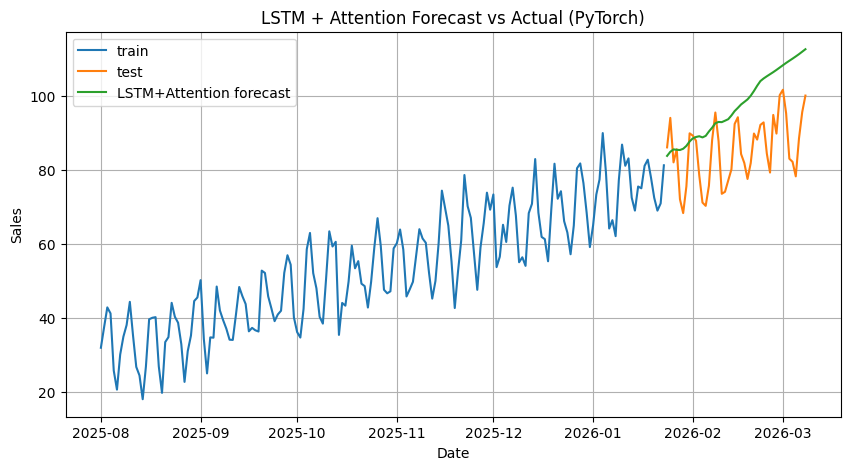

In [27]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train.values, label="train")
plt.plot(test.index, test.values, label="test")
plt.plot(test.index, pred, label="LSTM+Attention forecast")
plt.title("LSTM + Attention Forecast vs Actual (PyTorch)")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.grid(True); plt.show()


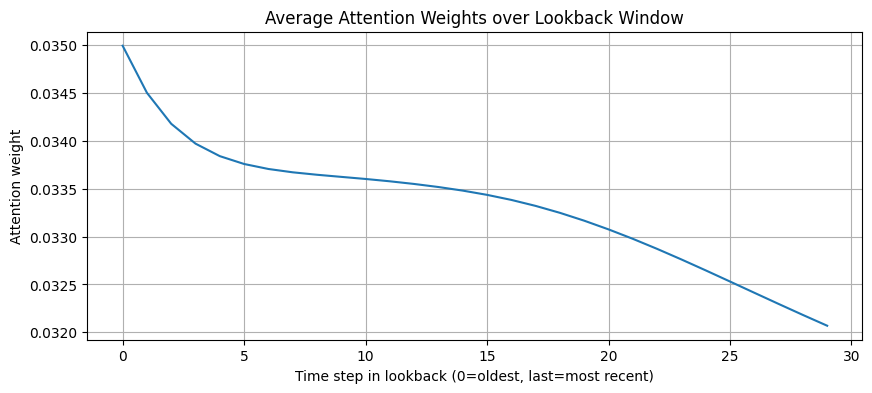

In [28]:
avg_attn = attn_all.mean(axis=0)  # (lookback,)

plt.figure(figsize=(10,4))
plt.plot(np.arange(LOOKBACK), avg_attn)
plt.title("Average Attention Weights over Lookback Window")
plt.xlabel("Time step in lookback (0=oldest, last=most recent)")
plt.ylabel("Attention weight")
plt.grid(True)
plt.show()
